# Tutorial : A kernel overview

### Nicolas Durrande, James Hensman, Mike Smith 2013, 2014, 2017

Much of your time working with Gaussian Processes will be spent crafting appropriate kernels for your problem. This is a massive topic, and this overview will just give you a few pointers in using kernels in GPy.

Background reading I'd recommend includes <a href="https://moodle2.units.it/pluginfile.php/24257/mod_resource/content/1/Rasmussen_Williams_2006_Gaussian_processes_for_machine_learning.pdf">chapter 4 of Rasmussen and Williams</a>. The <a href="http://www.cs.toronto.edu/~duvenaud/cookbook/">kernel cookbook</a> is also a quick introduction to give you a few ideas.

In [4]:
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## overview

The kernel describes how different points in the input covary. For example you might believe that nearby points are likely to be similar, while distant points are not and you might believe this covariance varies smoothly. For this we might want to use the highly popular RBF (EQ) kernel. However we can imagine far more complex kernels.

We begin by looking at how to specify these kernels. Almost all kernels come with a set of **hyperparameters** that need setting in some way (either manually, or with ML estimation, etc).

## basics: construction, printing and plotting

For most kernels, the input dimension (domain) is the only mandatory parameter to define a kernel object (this is the number of dimensions in the input) - other hyperparameters are set to default values.

However, it is also possible, and usually preferable, to specify the values of these other parameters. For example, the three following commands are valid for defining a squared exponential kernel (ie rbf or Gaussian).

In [5]:
ker1 = GPy.kern.RBF(1)  # The default lengthscale and variance are set: Equivalent to ker1 = GPy.kern.rbf(input_dim=1, variance=1., lengthscale=1.)
ker2 = GPy.kern.RBF(input_dim=1, variance = .75, lengthscale=2.)
ker3 = GPy.kern.RBF(1, .5, .5)

A  `print` and a `plot` function are implemented to represent kernel objects.

In [7]:
print(ker2)

  rbf.         |  value  |  constraints  |  priors
  variance     |   0.75  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |        


We can see the name and the two hyperparameters, with their values, constraints and any priors on them.

Below we plot these three kernels: This plots the covariance between points and $X=0$ for the three.

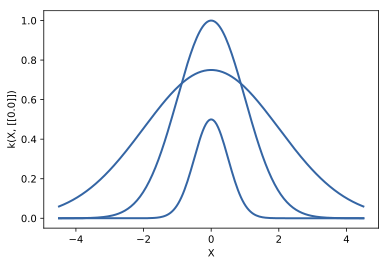

In [11]:
ker1.plot(ax=plt.gca())
ker2.plot(ax=plt.gca())
ker3.plot(ax=plt.gca());

## Implemented kernels

Many kernels are already implemented in GPy. The following figure gives a summary of some of them (a comprehensive list can be list can be found but typing `GPy.kern.<tab>`):

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


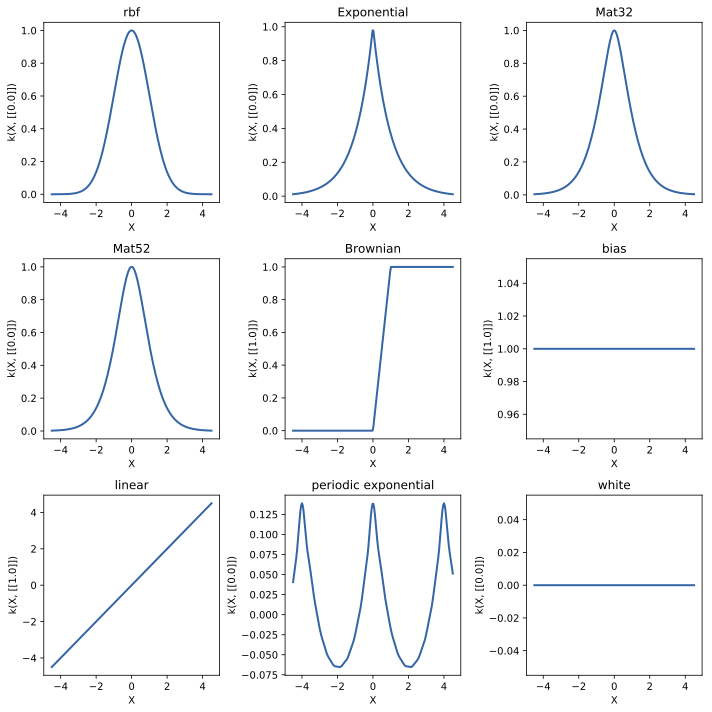

In [38]:
figure, axes = plt.subplots(3,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), GPy.kern.Matern52(1), GPy.kern.Brownian(1), GPy.kern.Bias(1), GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1,period=4.0), GPy.kern.White(1), GPy.kern.Cosine(1)]
comparisonx = [0,0,0,0,1,1,1,0,0]
for k,a,x in zip(kerns, axes.flatten(),comparisonx):
    k.plot(ax=a, x=x)
    a.set_title(k.name.replace('_', ' '))

To further illustrate, we fit a GP with these kernels to a simple sinusoid+linear set of data. Hopefully this gives an idea about how the kernels will perform. Each is optimised - potentially not to a perfect set of hyperparameters though. Also some kernels will not perform well - as the data is not well described with all the kernels.

I've added a few combined kernels, to illustrate how we can improve the model by using our domain knowledge to select more reasonable kernels.

 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:594: RuntimeWarning:invalid value encountered in cos
 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


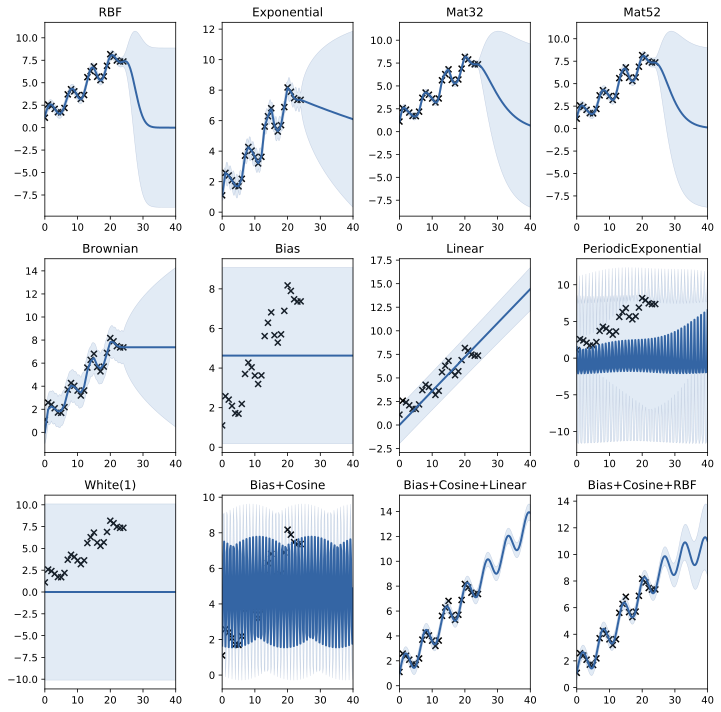

In [46]:
X = np.arange(0,25,1)[:,None]
Y = X*.3+np.sin(X)+1.0+np.random.randn(25,1)*.2
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), GPy.kern.Matern52(1), 
         GPy.kern.Brownian(1), GPy.kern.Bias(1), GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1,period=4.0), 
         GPy.kern.White(1), GPy.kern.Bias(1)+GPy.kern.Cosine(1), 
         GPy.kern.Bias(1)+GPy.kern.Cosine(1)+GPy.kern.Linear(1),GPy.kern.Bias(1)+GPy.kern.Cosine(1)+GPy.kern.RBF(1)]
titles = ['RBF','Exponential','Mat32','Mat52','Brownian','Bias','Linear','PeriodicExponential','White(1)',
          'Bias+Cosine','Bias+Cosine+Linear','Bias+Cosine+RBF']
figure, axes = plt.subplots(3,4, figsize=(10,10), tight_layout=True)
for k,a,t in zip(kerns, axes.flatten(),titles):
    m = GPy.models.GPRegression(X,Y,k)
    m.optimize_restarts(verbose=False)
    m.plot(ax=a,plot_limits=[0,40],legend=False)
    #print(m)
    a.set_title(t)

## Operations to combine kernels

In GPy, kernel objects can be added or multiplied to create a mutlitude of kernel objects. Parameters and their gradients are handled automatically, and so appear in the combined objects. When kernels are used inside GP objects all the necessary graidents are automagically computed using the chain-rule. 

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        
  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


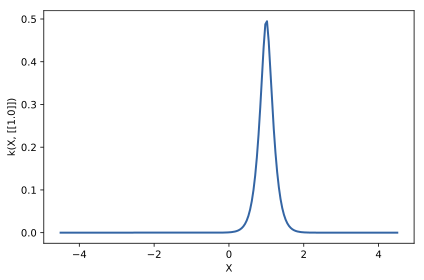

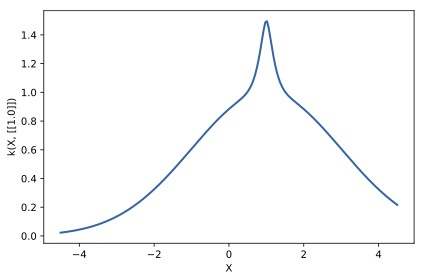

In [48]:
# Product of kernels
k1 = GPy.kern.RBF(1,1.,2.)
k2 = GPy.kern.Matern32(1, 0.5, 0.2)
k_prod = k1 *k2
print(k_prod)
k_prod.plot()



# Sum of kernels
k1 = GPy.kern.RBF(1,1.,2.)
k2 = GPy.kern.Matern32(1, 0.5, 0.2)
k_add = k1 + k2
print(k_add)
k_add.plot()

Note that the kernels that have been added are pythonic in that the objects remain linked: changing parameters of an add kernel changes those of the constituent parts, and vice versa

In [51]:
print(k1)
print("\n")
k_add.rbf.variance = 12.
print(k1)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |        


  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    2.0  |      +ve      |        


## Operating on different domains

When multiplying and adding kernels, there are two general possibilites, one can assume that the kernels to add/multiply are defined on the same space or on different spaces:

 * a kernel over $\mathbb{R} \times \mathbb{R}: k(x,x') = k_1(x,x') \times k_2(x,x')$
 * a kernel over $\mathbb{R}^2 \times \mathbb{R}^2: k(\mathbf{x},\mathbf{x}') = k_1(x_1,x'_1) \times k_2(x_2,x'_2)$
 
To keep things as general as possible, in GPy kernels are assigned `active_dims` which tell the kernel what to work on. To create a kernel which is a product of krnels on different spaces, we can do

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


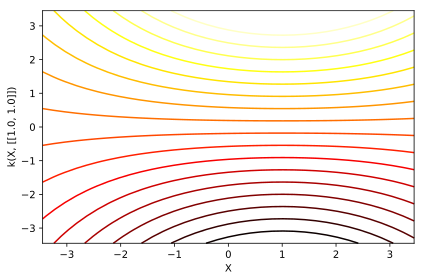

In [52]:
k1 = GPy.kern.Linear(input_dim=1, active_dims=[0]) # works on the first column of X, index=0
k2 = GPy.kern.ExpQuad(input_dim=1, lengthscale=3, active_dims=[1]) # works on the second column of X, index=1
k = k1 * k2
k.plot(x=np.ones((1,2)))

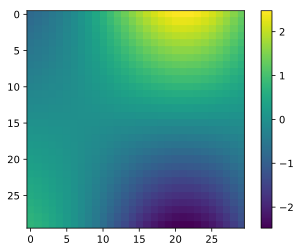

In [53]:
def plot_sample(k):
    xx, yy = np.mgrid[-3:3:30j, -3:3:30j]
    X = np.vstack((xx.flatten(), yy.flatten())).T
    K = k.K(X)
    s = np.random.multivariate_normal(np.zeros(X.shape[0]), K)
    #plt.contourf(xx, yy, s.reshape(*xx.shape), cmap=plt.cm.hot)
    plt.imshow(s.reshape(*xx.shape), interpolation='nearest')
    plt.colorbar()
plot_sample(k)

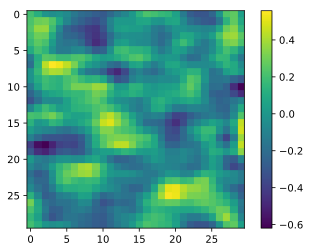

In [54]:
k1 = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[0], period=6, lower=-10, upper=10)# + GPy.kern.Bias(1, variance=0, active_dims=[0])
k2 = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[1], period=8, lower=-10, upper=10)# + GPy.kern.Bias(1, variance=0, active_dims=[0])

#k2 = GPy.kern.ExpQuad(1, active_dims=[1])
k = k1 * k2
plot_sample(k)